<a href="https://www.kaggle.com/code/lucasrathgeb/binary-classification-of-bank-churn?scriptVersionId=159052032" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
from scipy.stats import uniform, randint
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.constraints import MaxNorm
from keras import regularizers

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, Normalizer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression, f_regression, mutual_info_regression

from sklearn.preprocessing import OrdinalEncoder
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

In [3]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [4]:
train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
train_data.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [6]:
print(train_data.isnull().sum())

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


No null values

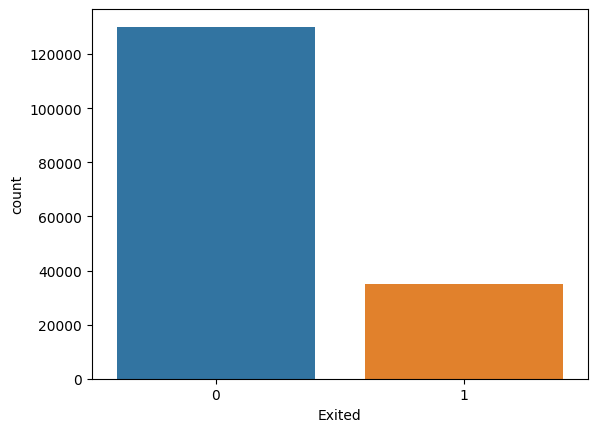

In [7]:
sns.barplot(x=train_data["Exited"].value_counts().index, y=train_data["Exited"].value_counts())
plt.show()

{'CreditScore', 'NumOfProducts', 'Age', 'Balance', 'Exited', 'HasCrCard', 'IsActiveMember', 'Tenure', 'id', 'CustomerId', 'EstimatedSalary'}
{'Gender', 'Surname', 'Geography'}


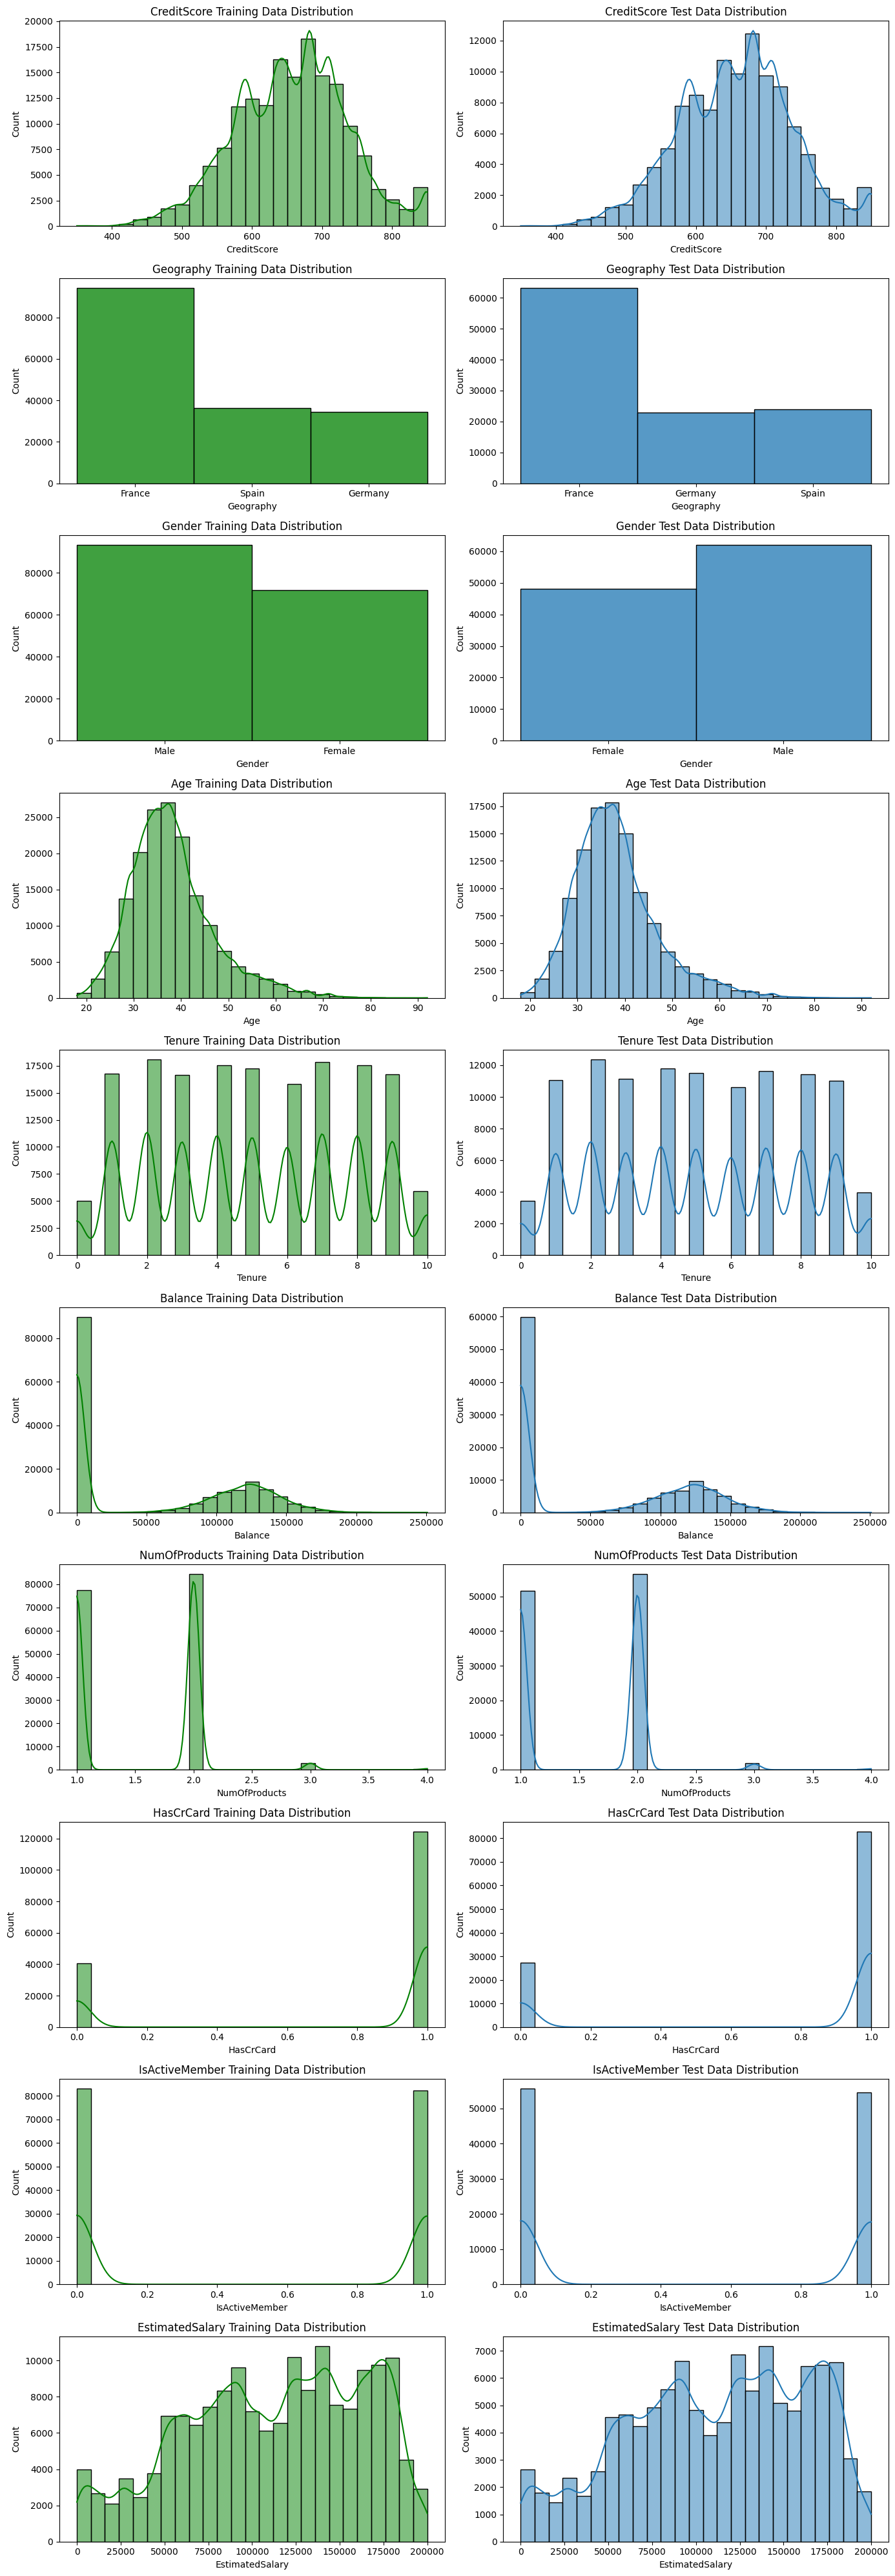

In [8]:
X_train = train_data.copy()

numeric_cols = set(X_train._get_numeric_data().columns.values)
print(numeric_cols)
categorical_cols = set(X_train.columns.values) - set(numeric_cols)
print(categorical_cols)

train = X_train.copy()
train = train.drop(["id", "CustomerId", "Surname", "Exited"],axis=1)


cols = train.columns.values
# print("id" in numeric_cols)
num_rows = len(cols)
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(14, num_rows*4))

for i in range(num_rows):
    sns.histplot(x=cols[i],
                 data=X_train, 
                 bins=25, 
                 color='green', 
                 kde=(cols[i] in numeric_cols),
                 ax=ax[i,0])
    ax[i,0].set_title(f'{cols[i]} Training Data Distribution')

    sns.histplot(x=cols[i], 
                 data=test_data, 
                 bins=25, 
                 kde=(cols[i] in numeric_cols), 
                 ax=ax[i,1])
    ax[i,1].set_title(f'{cols[i]} Test Data Distribution')
    
plt.tight_layout() 
plt.show()

In [9]:
def convert_binary_cats(data, features):
    for feature in features:
        temp_df = pd.get_dummies(data[feature]).astype('float32')
    #     print(genders)
        data = data.drop(feature, axis=1)
        data[feature] = temp_df[temp_df.columns.values[0]]
        
    return data

In [10]:
X_train = train_data.copy()

bin_cats = ["Gender"]

X_train = convert_binary_cats(X_train, bin_cats)
print(X_train)

            id  CustomerId         Surname  CreditScore Geography   Age  \
0            0    15674932  Okwudilichukwu          668    France  33.0   
1            1    15749177   Okwudiliolisa          627    France  33.0   
2            2    15694510           Hsueh          678    France  40.0   
3            3    15741417             Kao          581    France  34.0   
4            4    15766172       Chiemenam          716     Spain  33.0   
...        ...         ...             ...          ...       ...   ...   
165029  165029    15667085            Meng          667     Spain  33.0   
165030  165030    15665521       Okechukwu          792    France  35.0   
165031  165031    15664752            Hsia          565    France  31.0   
165032  165032    15689614          Hsiung          554     Spain  30.0   
165033  165033    15732798         Ulyanov          850    France  31.0   

        Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0            3       0.00   

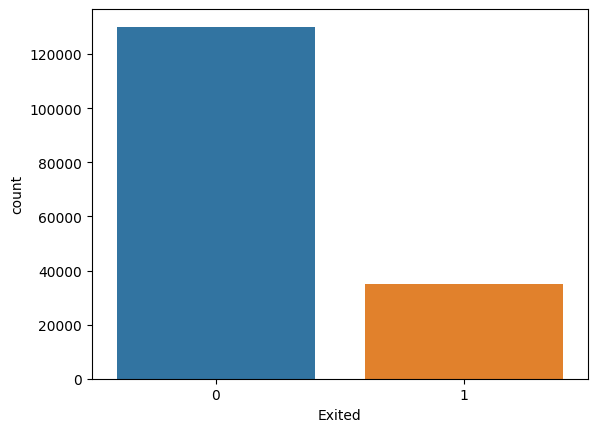

In [11]:
sns.barplot(x=X_train["Exited"].value_counts().index, y=X_train["Exited"].value_counts())
plt.show()

In [12]:
y_train = X_train["Exited"]

cols_to_drop = ["id", "CustomerId", "Surname", "Exited"]
X_train = X_train.drop(cols_to_drop,axis=1)

X_train = pd.get_dummies(X_train).astype('float32')

print(X_train)

        CreditScore   Age  Tenure        Balance  NumOfProducts  HasCrCard  \
0             668.0  33.0     3.0       0.000000            2.0        1.0   
1             627.0  33.0     1.0       0.000000            2.0        1.0   
2             678.0  40.0    10.0       0.000000            2.0        1.0   
3             581.0  34.0     2.0  148882.546875            1.0        1.0   
4             716.0  33.0     5.0       0.000000            2.0        1.0   
...             ...   ...     ...            ...            ...        ...   
165029        667.0  33.0     2.0       0.000000            1.0        1.0   
165030        792.0  35.0     3.0       0.000000            1.0        0.0   
165031        565.0  31.0     5.0       0.000000            1.0        1.0   
165032        554.0  30.0     7.0  161533.000000            1.0        0.0   
165033        850.0  31.0     1.0       0.000000            1.0        1.0   

        IsActiveMember  EstimatedSalary  Gender  Geography_Fran

In [13]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 400,
 'subsample': 0.5}

In [14]:
from xgboost import XGBClassifier

model = XGBClassifier(colsample_bytree= 0.5,
 learning_rate= 0.05,
 max_depth= 5,
 n_estimators= 400,
 subsample= 0.5)

model.fit(np.array(X_train), 
             np.array(y_train))

xgb_preds = pd.DataFrame(model.predict(X_train))
print(xgb_preds)

        0
0       0
1       0
2       0
3       0
4       0
...    ..
165029  0
165030  0
165031  0
165032  0
165033  0

[165034 rows x 1 columns]


In [15]:
proba = pd.DataFrame(model.predict_proba(X_train))
print(proba)
print(proba[1])

               0         1
0       0.985508  0.014492
1       0.992871  0.007129
2       0.962433  0.037567
3       0.972931  0.027069
4       0.990487  0.009513
...          ...       ...
165029  0.868324  0.131676
165030  0.657362  0.342638
165031  0.916475  0.083525
165032  0.914505  0.085495
165033  0.791329  0.208671

[165034 rows x 2 columns]
0         0.014492
1         0.007129
2         0.037567
3         0.027069
4         0.009513
            ...   
165029    0.131676
165030    0.342638
165031    0.083525
165032    0.085495
165033    0.208671
Name: 1, Length: 165034, dtype: float32


# prepare test data

In [16]:
X_test = test_data.copy()
X_test = convert_binary_cats(X_test, bin_cats)
cols_to_drop = ["id", "CustomerId", "Surname"]
X_test = X_test.drop(cols_to_drop,axis=1)

X_test = pd.get_dummies(X_test).astype('float32')

print(X_test)

        CreditScore   Age  Tenure        Balance  NumOfProducts  HasCrCard  \
0             586.0  23.0     2.0       0.000000            2.0        0.0   
1             683.0  46.0     2.0       0.000000            1.0        1.0   
2             656.0  34.0     7.0       0.000000            2.0        1.0   
3             681.0  36.0     8.0       0.000000            1.0        1.0   
4             752.0  38.0    10.0  121263.617188            1.0        1.0   
...             ...   ...     ...            ...            ...        ...   
110018        570.0  29.0     7.0  116099.820312            1.0        1.0   
110019        575.0  36.0     4.0  178032.531250            1.0        1.0   
110020        712.0  31.0     2.0       0.000000            2.0        1.0   
110021        709.0  32.0     3.0       0.000000            1.0        1.0   
110022        621.0  37.0     7.0   87848.390625            1.0        1.0   

        IsActiveMember  EstimatedSalary  Gender  Geography_Fran

In [17]:
# preds = pd.DataFrame(model1.predict(X_test))

preds = pd.DataFrame(model.predict_proba(X_test))[1]

print(preds)

0         0.023176
1         0.823052
2         0.027141
3         0.225684
4         0.338167
            ...   
110018    0.041480
110019    0.113666
110020    0.020312
110021    0.157492
110022    0.168838
Name: 1, Length: 110023, dtype: float32


In [18]:
#submission
submission = pd.concat([test_data["id"], preds],axis=1)
submission.rename(columns={0: "Exited"}, inplace=True)
print(submission)
submission.to_csv('submission.csv',index=False)
submission.describe()

            id         1
0       165034  0.023176
1       165035  0.823052
2       165036  0.027141
3       165037  0.225684
4       165038  0.338167
...        ...       ...
110018  275052  0.041480
110019  275053  0.113666
110020  275054  0.020312
110021  275055  0.157492
110022  275056  0.168838

[110023 rows x 2 columns]


,id,1
count,110023.000000,110023.000000
mean,220045.000000,0.211167
std,31761.048671,0.261414
min,165034.000000,0.003254
25%,192539.500000,0.027479
50%,220045.000000,0.087177
75%,247550.500000,0.293545
max,275056.000000,0.992724
